# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# [1]. Reading Data

In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect('E:\\IIT Kanpur\\Placements\\Projects\\Amazon Fine Food Reviews\\Dataset\\database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

In [3]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

In [4]:
#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [5]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [6]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [7]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [8]:
display['COUNT(*)'].sum()

393063

#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [10]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [14]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [18]:
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')

In [19]:
def cleanhtml(sent):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sent)
    return cleantext

In [20]:
def cleanpunc(sent):
    cleaned = re.sub(r'[?|!|\|"|#]', r'', sent)
    cleaned = re.sub(r"[']", r'', cleaned)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r' ', cleaned)
    return cleaned

In [21]:
i = 0
str1 = ' '
final_string = []
all_positive_words = [] # store words from positive reviews
all_negative_words = [] # words from negative reviews
s = ''

from tqdm import tqdm

for sent in tqdm(final['Text'].values):
    filtered_sent = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words) > 2)):
                if(cleaned_words.lower() not in stop):
                    s = (sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sent.append(s)
                    if final['Score'].iloc[i] == 0:
                        all_positive_words.append(s)
                    if final['Score'].iloc[i] == 1:
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue
                
    str1 = b" ".join(filtered_sent)
    
    final_string.append(str1)
    i = i + 1

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [14:42<00:00, 412.43it/s]


In [22]:
final['CleanedText'] = final_string

In [23]:
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...


In [24]:
final['CleanedText'].iloc[0]

b'witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg'

In [25]:
# this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and
# he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new 
# words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my
# son will STILL be able to recite from memory when he is  in college

<h2><font color='red'>[3.2] Preprocess Summary</font></h2>

In [26]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [29]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(final_string)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(final_string)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaargh', 'aaaaaaaaagghh', 'aaaaaaah', 'aaaaaaahhhhhh']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 71624)
the number of unique words  71624


## [4.2] Bi-Grams and n-Grams.

In [30]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range = (1,2), min_df = 10)#, max_features = 5000)
final_bigram_counts = count_vect.fit_transform(final_string)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 206995)
the number of unique words including both unigrams and bigrams  206995


## [4.3] TF-IDF

In [31]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(final_string)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(final_string)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aaa', 'aaah', 'aafco', 'aah', 'ab', 'aback', 'abandon', 'abbey', 'abbi', 'abbott']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (364171, 206995)
the number of unique words including both unigrams and bigrams  206995


In [32]:
#some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 
#                                                  'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
#==================================================
#the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
#the shape of out text TFIDF vectorizer  (4986, 3144)
#the number of unique words including both unigrams and bigrams  3144

In [33]:
features = tf_idf_vect.get_feature_names()

In [34]:
features[100:110]

['abl provid',
 'abl pull',
 'abl pump',
 'abl purchas',
 'abl push',
 'abl put',
 'abl quick',
 'abl read',
 'abl receiv',
 'abl replac']

In [35]:
print(final_tf_idf[0, :].toarray()[0])

[0. 0. 0. ... 0. 0. 0.]


In [36]:
def top_tfidf_features(row, features, top_n = 25):
    '''
    Get top n tfidf values in row and return them with their corresponding feature names.
    '''
    
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [37]:
top_tfidf = top_tfidf_features(final_tf_idf[0, :].toarray()[0], features, 10)

In [38]:
top_tfidf

,feature,tfidf
0,recit,0.402341
1,book,0.338286
2,witti,0.201170
3,book make,0.201170
4,littl book,0.198431
5,car drive,0.194981
6,droop,0.193004
7,son still,0.190399
8,whale,0.188853
9,will bet,0.188127


## [4.4] Word2Vec

In [27]:
# Train your own Word2Vec model using your own text corpus
i = 0
list_of_sentance=[]
for sentance in tqdm(final_string):
    list_of_sentance.append(sentance.split())

100%|██████████████████████████████████████████████████████████████████████| 364171/364171 [00:02<00:00, 126993.93it/s]


In [28]:
print(list_of_sentance[0])

[b'witti', b'littl', b'book', b'make', b'son', b'laugh', b'loud', b'recit', b'car', b'drive', b'along', b'alway', b'sing', b'refrain', b'hes', b'learn', b'whale', b'india', b'droop', b'love', b'new', b'word', b'book', b'introduc', b'silli', b'classic', b'book', b'will', b'bet', b'son', b'still', b'abl', b'recit', b'memori', b'colleg']


In [29]:
list_of_sentance[0][0]

b'witti'

In [30]:
# str(b'hello', encoding)
encoding = 'utf-8'
a = str(list_of_sentance[0][0], encoding)

In [31]:
encoding = 'utf-8'
list_to_sent_str = []
for sent in tqdm(list_of_sentance):
    s = []
    for w in sent:
        temp = str(w, encoding)
        s.append(temp)
    list_to_sent_str.append(s)

100%|███████████████████████████████████████████████████████████████████████| 364171/364171 [00:07<00:00, 47122.97it/s]


In [32]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

# is_your_ram_gt_16g=False
# want_to_use_google_w2v = False

want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    # size = 50 dimension of the vector
    # workers = 4 number of computer used for computing
    
    w2v_model = Word2Vec(list_to_sent_str, min_count=2, size=50, workers=4)
    
    print(w2v_model.wv.most_similar('great'))
    
    print('='*50)
    
    print(w2v_model.wv.most_similar('worst'))
    
# elif want_to_use_google_w2v and is_your_ram_gt_16g:
#     if os.path.isfile('GoogleNews-vectors-negative300.bin'):
#         w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
#         print(w2v_model.wv.most_similar('great'))
#         print(w2v_model.wv.most_similar('worst'))
#     else:
#         print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantast', 0.8554610013961792), ('good', 0.8539867401123047), ('terrif', 0.8416933417320251), ('excel', 0.8376325368881226), ('awesom', 0.817306637763977), ('wonder', 0.7849027514457703), ('nice', 0.7649551630020142), ('perfect', 0.7407717108726501), ('fabul', 0.701228678226471), ('decent', 0.6834162473678589)]
[('nastiest', 0.8511088490486145), ('greatest', 0.7485708594322205), ('disgust', 0.7450594305992126), ('best', 0.7162209153175354), ('horribl', 0.7159982919692993), ('nicest', 0.7000775337219238), ('tastiest', 0.6878936290740967), ('terribl', 0.6872791051864624), ('wors', 0.6744000911712646), ('aw', 0.6682536005973816)]


In [33]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 2 times ",len(w2v_words)) # as min_count = 2
print("*"*50)
print("sample words ", w2v_words[0:50])

number of words that occured minimum 2 times  37669
**************************************************
sample words  ['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'grew', 'read', 'sendak', 'watch', 'realli', 'rosi', 'movi', 'incorpor', 'howev', 'miss', 'hard', 'cover', 'version', 'paperback', 'seem', 'kind', 'flimsi', 'take', 'two']


In [34]:
w2v_model.wv.most_similar('dad')

[('sister', 0.8739379048347473),
 ('father', 0.8647642731666565),
 ('fianc', 0.8590965867042542),
 ('mom', 0.8452954292297363),
 ('boyfriend', 0.8366001844406128),
 ('girlfriend', 0.8313435316085815),
 ('niec', 0.8215233087539673),
 ('nephew', 0.8213306665420532),
 ('brother', 0.813717246055603),
 ('grandchildren', 0.8071005344390869)]

In [35]:
w2v_model.wv.similarity("love", "hate")

0.53179073

## [4.4.1] Converting text into vectors using wAvg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [36]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_to_sent_str): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, 
                            # you might need to change this to 300 if you use google's w2v
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [12:56<00:00, 468.96it/s]

364171
50


#### [4.4.1.2] TFIDF weighted W2v

In [101]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer(min_df = 2)
model.fit(final_string)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [102]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

In [103]:
len(tfidf_feat), len(w2v_words)

(35806, 37669)

In [104]:
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_to_sent_str): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent)) # this line evaluates idf * tf
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [2:29:15<00:00, 40.66it/s]


In [105]:
tfidf_sent_vectors = np.asarray(tfidf_sent_vectors)
tfidf_sent_vectors_df = pd.DataFrame(tfidf_sent_vectors)

In [106]:
tfidf_sent_vectors_df.to_csv('E:\\IIT Kanpur\\Placements\\Projects\\Amazon Fine Food Reviews\\w2v_tfidf.csv')

# [5] Applying TSNE

<ol> 
    <li> you need to plot 4 tsne plots with each of these feature set
        <ol>
            <li>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ol>
    </li>
    <li> <font color='blue'>Note 1: The TSNE accepts only dense matrices</font></li>
    <li> <font color='blue'>Note 2: Consider only 5k to 6k data points </font></li>
</ol>

In [75]:
# https://github.com/pavlin-policar/fastTSNE you can try this also, this version is little faster than sklearn 
import numpy as np
from sklearn.manifold import TSNE
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt

In [159]:
iris = datasets.load_iris()
x = iris['data']
y = iris['target']

In [162]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

In [164]:
X_embedding = tsne.fit_transform(x)
# if x is a sparse matrix you need to pass it as
# X_embedding = tsne.fit_transform(x.toarray()) , .toarray() will convert the sparse matrix into dense matrix

In [166]:
for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))

array([[ 17.85515022, -19.19898987,   0.        ],
       [ 20.32422066, -19.40589142,   0.        ],
       [ 20.45853233, -18.34332275,   0.        ],
       [ 20.73033142, -18.52080536,   0.        ],
       [ 17.79631615, -19.55884933,   0.        ],
       [ 15.67910767, -19.03488159,   0.        ],
       [ 20.165205  , -17.75961113,   0.        ],
       [ 18.51021385, -18.81073952,   0.        ],
       [ 21.50368881, -18.62551117,   0.        ],
       [ 19.90232277, -19.14811325,   0.        ],
       [ 16.26650047, -19.05858231,   0.        ],
       [ 19.16759872, -18.26033783,   0.        ],
       [ 20.64858246, -19.18592262,   0.        ],
       [ 21.73043633, -18.12826157,   0.        ],
       [ 14.97392941, -19.53133774,   0.        ],
       [ 14.94291019, -19.86068916,   0.        ],
       [ 15.79548645, -19.59981155,   0.        ],
       [ 17.76393127, -19.0086174 ,   0.        ],
       [ 15.33883286, -18.88408089,   0.        ],
       [ 16.79922485, -19.67383

In [167]:
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])

In [169]:
colors = {0:'red', 1:'blue', 2:'green'}

In [170]:
for_tsne_df.head()

,Dimension_x,Dimension_y,Score
0,17.855150,-19.198990,0.0
1,20.324221,-19.405891,0.0
2,20.458532,-18.343323,0.0
3,20.730331,-18.520805,0.0
4,17.796316,-19.558849,0.0


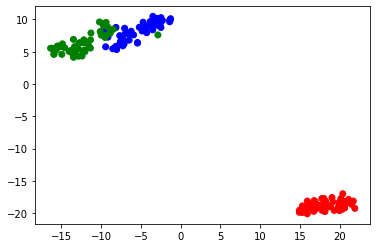

In [171]:
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()

# avg. word2vec

### Random Sample from avg word2vec
in total there are 364171 rows, randomly sampling 5% from whole data

In [39]:
score = np.asarray(final['Score'])

In [44]:
w2v_avg = np.asarray(sent_vectors)

In [47]:
score = score.astype('float')

In [53]:
score = score.reshape((364171,1))

In [55]:
final_arr = np.concatenate((w2v_avg, score), axis = 1)
final_arr.shape

(364171, 51)

In [60]:
np.random.seed(1)
rand_ind = np.random.choice(final_arr.shape[0], int(0.05 * final_arr.shape[0]), replace=False)

In [118]:
rand_ind

array([363544,  25383, 268135, ..., 109283, 253515, 360559])

In [63]:
final_arr_rand = final_arr[rand_ind, :]

array([[ 0.95803559, -0.70050965,  0.13684126, ...,  0.24170973,
         0.01415964,  1.        ],
       [ 1.18918112,  0.06596829, -0.22354803, ..., -0.15822264,
        -0.33580873,  1.        ],
       [ 0.99723842,  0.9281132 ,  0.24813964, ...,  0.14656998,
        -0.20077198,  1.        ],
       ...,
       [-0.49124758, -0.37085523, -0.84836868, ..., -0.09163905,
        -0.42542383,  1.        ],
       [ 1.18560802, -0.04493895, -0.21687964, ...,  0.13738781,
        -0.64172544,  1.        ],
       [-0.19389285, -0.19361707, -0.01770726, ...,  0.2538095 ,
        -1.13637873,  0.        ]])

In [64]:
final_arr_rand.shape

(18208, 51)

In [72]:
x = final_arr_rand[:, :50]
y = final_arr_rand[:, 50:]

# Applying t-SNE

In [76]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

In [77]:
X_embedding = tsne.fit_transform(x)

In [79]:
for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))

In [82]:
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])

In [84]:
colors = {0:'red', 1:'blue'}

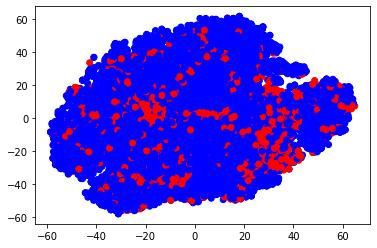

In [85]:
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()

# K-means clustering

In [91]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    print("1", i)
    kmeans.fit(x)
    print("2", i)
    wcss.append(kmeans.inertia_)
    print("3", i)

1 1
2 1
3 1
1 2
2 2
3 2
1 3
2 3
3 3
1 4
2 4
3 4
1 5
2 5
3 5
1 6
2 6
3 6
1 7
2 7
3 7
1 8
2 8
3 8
1 9
2 9
3 9
1 10
2 10
3 10


In [92]:
wcss

[309844.6526303324,
 277867.1190543366,
 256446.4849537852,
 241863.20595108057,
 233132.1383847457,
 226026.6626309437,
 220213.81542622115,
 215925.8946888173,
 212200.2017497787,
 208644.08908950034]

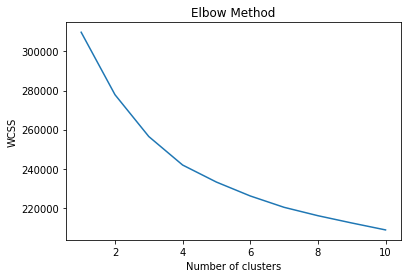

In [94]:
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [95]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_pred = kmeans.fit_predict(x)

In [100]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

conf_mat = confusion_matrix(y, y_pred)
print(conf_mat)

print(classification_report(y, y_pred))

[[1583 1264]
 [6851 8510]]
              precision    recall  f1-score   support

         0.0       0.19      0.56      0.28      2847
         1.0       0.87      0.55      0.68     15361

    accuracy                           0.55     18208
   macro avg       0.53      0.56      0.48     18208
weighted avg       0.76      0.55      0.62     18208



# Word2Vec with TF-IDF
random sampling 5% of total

In [110]:
final_arr = np.concatenate((tfidf_sent_vectors, score), axis = 1)
print(final_arr.shape)

np.random.seed(1)
rand_ind = np.random.choice(final_arr.shape[0], int(0.05 * final_arr.shape[0]), replace=False)

final_arr_rand = final_arr[rand_ind, :]
print(final_arr_rand.shape)

x = final_arr_rand[:, :50]
y = final_arr_rand[:, 50:]
print(x.shape, y.shape)

(364171, 51)
(18208, 51)


# Applying k-means clustering

In [113]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    print("1", i)
    kmeans.fit(x)
    print("2", i)
    wcss.append(kmeans.inertia_)
    print("3", i)
    
wcss

1 1
2 1
3 1
1 2
2 2
3 2
1 3
2 3
3 3
1 4
2 4
3 4
1 5
2 5
3 5
1 6
2 6
3 6
1 7
2 7
3 7
1 8
2 8
3 8
1 9
2 9
3 9
1 10
2 10
3 10


[491765.812296448,
 441991.8775707955,
 405861.18571528833,
 381990.3506219609,
 364544.3404010512,
 352612.67189615086,
 343237.68157927244,
 334078.2323881241,
 327871.73382083006,
 321839.99567907234]

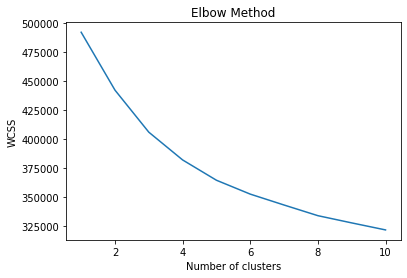

In [114]:
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [115]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_pred = kmeans.fit_predict(x)

In [116]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

conf_mat = confusion_matrix(y, y_pred)
print(conf_mat)

print(classification_report(y, y_pred))

[[ 2328   517]
 [11871  3492]]
              precision    recall  f1-score   support

         0.0       0.16      0.82      0.27      2845
         1.0       0.87      0.23      0.36     15363

    accuracy                           0.32     18208
   macro avg       0.52      0.52      0.32     18208
weighted avg       0.76      0.32      0.35     18208



# Gaussian Mixture Model Clustering

In [ ]:
# TODO: Import GaussianMixture
from sklearn.mixture import GaussianMixture

# TODO: Create an instance of Gaussian Mixture with 3 components
gmm = GaussianMixture(n_components=3).fit(X)

# TODO: fit the dataset
gmm = gmm.fit(X)

# TODO: predict the clustering labels for the dataset
pred_gmm = gmm.predict(X)

# Plot the clusters
plt.figure( figsize=(16,12))
plt.scatter(X[:,0], X[:,1], c=pred_gmm, edgecolor='black', lw=1.5, s=100, cmap=plt.get_cmap('viridis'))
plt.show()